In [1]:
import numpy as np
import xarray as xr

In [2]:
a = 6.371e6  # 地球半径 m
g = 9.8  # 重力 m/s^2
omg = 7.292e-5  # 自転角速度 rad/s

In [3]:
ds = xr.open_dataset('test3.nc')

In [4]:
ds['GeopotentialHeight']

<xarray.DataArray 'GeopotentialHeight' (lev: 37, lat: 145, lon: 288)>
[1545120 values with dtype=float32]
Coordinates:
  * lev      (lev) int64 1 2 3 5 7 10 20 30 ... 825 850 875 900 925 950 975 1000
  * lat      (lat) float64 90.0 88.75 87.5 86.25 ... -86.25 -87.5 -88.75 -90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Attributes:
    time:     1958-01-01 00:00:00
    units:    gpm
    dataset:  JRA-55

In [5]:
dlat, dlon = -1.25, 1.25  # deg
dlat, dlon = np.deg2rad(dlat), np.deg2rad(dlon)  # rad

lons, lats = np.meshgrid(ds.lon, ds.lat)  # deg
phi = np.deg2rad(lats)  # rad
cos_phi = np.cos(phi)  # 緯度毎のcos
f = 2 * omg * np.sin(phi)  # 緯度毎のコリオリパラメタ /s

-0.02181661564992912 0.02181661564992912


In [6]:
z = ds.sel(lev=500).to_array()[0]
#z = np.where((130 <= lons)&(lons <= 150), z500, np.nan)
z.shape

(145, 288)

In [7]:
#dzdy = np.gradient(z500, np.deg2rad(dlat))[0] / a
#dzdx = np.gradient(z500, np.deg2rad(dlon))[1] / a / cos_phi

#dzdy = (np.roll(z, -1, axis=0) - np.roll(z, 1, axis=0)) / (2 * dlat * a)
#dzdx = (np.roll(z, -1, axis=1) - np.roll(z, 1, axis=1)) / (2 * dlon * a * cos_phi)

dzdy = (np.roll(z, -1, axis=0) - np.roll(z, 1, axis=0)) / 2 / dlat / a
dzdx = (np.roll(z, -1, axis=1) - np.roll(z, 1, axis=1)) / 2 / dlon / a / cos_phi

In [12]:
# https://www.wizard-notes.com/entry/python/numpy-errstate-log
with np.errstate(divide='ignore', invalid='ignore'):
    ug = - dzdy * g / f
    vg = dzdx * g / f

In [13]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
%matplotlib inline

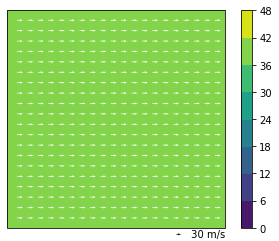

In [14]:
mproj = ccrs.Orthographic(135, 35)
dproj = ccrs.PlateCarree()

fig = plt.figure()
ax = fig.add_subplot(111, projection=mproj)

#ax.set_extent([130, 150, 30, 50])
ax.coastlines()

#c = ax.contourf(lons, lats, z, transform=dproj)
#plt.colorbar(c)

c = ax.contourf(lons, lats, np.sqrt(ug**2+vg**2), transform=dproj)
plt.colorbar(c)

#q = ax.quiver(lons[::5,::5], lats[::5, ::5], ug[::5, ::5], vg[::5, ::5],
q = ax.quiver(lons, lats, ug, vg, regrid_shape=20,
              #angles='uv', units='xy', fc='w', scale=50,
              fc='w', transform=dproj)
ax.quiverkey(q, 0.8, -0.03, 30,' 30 m/s', fc='k', labelpos='E')